# Digits Image Classification

In [1]:
import numpy as np
import pandas as pd
from numpy import linalg
from numpy.linalg import norm
from scipy.spatial.distance import squareform, pdist
import time

# We import sklearn.
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.manifold import Isomap
from sklearn.manifold import TSNE
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

# We'll hack a bit with the t-SNE code in sklearn 0.15.2.
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold.t_sne import (_joint_probabilities,
                                    _kl_divergence)
## ML methods##

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from mlens.visualization import corrmat

#from sklearn.utils.extmath import _ravel
# Random state.
RS = 20150101

# We'll use matplotlib for graphics.
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib
%matplotlib inline

#We import seaborn to make nice plots.
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})


[MLENS] backend: threading


In [2]:
data = pd.read_csv('voice.csv')

In [3]:
target = data.label
rows, columns = data.shape

In [4]:
data = data.iloc[:,0:(columns-1)]

In [5]:
target[target == 'male'] = 0
target[target == 'female'] = 1

/Users/skyler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/skyler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [6]:
pre_data = np.array(data)
y = np.array(target)

In [7]:
def plot_scatter(X_t, y, cap):
    plt.figure()
    plt.scatter(X_t[np.where(y == 0), 0],
                       X_t[np.where(y == 0), 1],
                       marker='x', color='g',
                       linewidth='1', alpha=0.8, label='Male')
    plt.scatter(X_t[np.where(y == 1), 0],
                       X_t[np.where(y == 1), 1],
                       marker='v', color='r',
                       linewidth='1', alpha=0.8, label='Female')

    plt.xlabel('Dim 1')
    plt.ylabel('Dim 2')
    plt.title(cap)
    plt.legend(loc='best')
    plt.savefig(cap+'.png')
    plt.show()

## Data Reduction techniques

Time taken to run Isomap is :  73.59696197509766


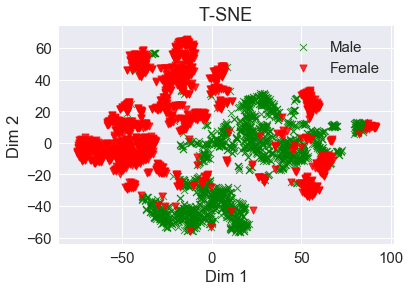

In [8]:
from sklearn.preprocessing import StandardScaler
X_scale = StandardScaler().fit_transform(pre_data)

# Sklearn TSNE
t0 = time.time()
Tsne_X_t = TSNE(n_components=2, init='pca', random_state=0).fit_transform(X_scale)
print("Time taken to run Isomap is : ", time.time() - t0)

plot_scatter(Tsne_X_t, y, 'T-SNE')

Time taken to run Isomap is :  4.765568971633911


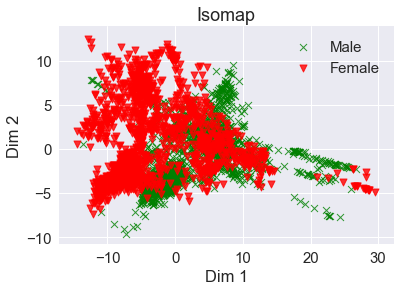

In [9]:
##Isomap##
t0 = time.time()
Iso_X_t = Isomap(n_components=2).fit_transform(X_scale)
print("Time taken to run Isomap is : ", time.time() - t0)
plot_scatter(Iso_X_t, y, 'Isomap')

Time taken to run LLE is :  0.6200010776519775


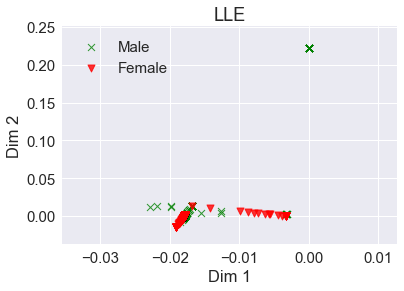

In [10]:
##LLE##
t0 = time.time()
LLE_X_t = LocallyLinearEmbedding(n_components=2).fit_transform(X_scale)
print("Time taken to run LLE is : ", time.time() - t0)
plot_scatter(LLE_X_t, y, 'LLE')

Time taken to run PCA is :  0.008141040802001953


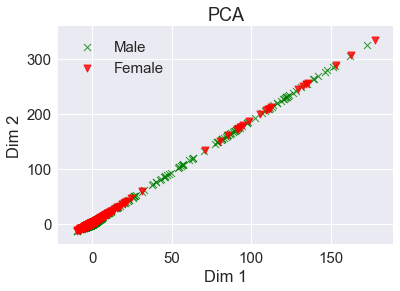

In [11]:
#PCA# linear data reduction techniques
pca = PCA(n_components=2)
t0 = time.time()
pca.fit(X_scale)
print("Time taken to run PCA is : ", time.time() - t0)
W = pca.components_
PCA_X_t = np.matmul(pre_data, W.T)
plot_scatter(PCA_X_t, y, 'PCA')

In [12]:
def make_meshgrid(x, y, h=.2):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

In [13]:
##Choose TSNE as our final data reduction techniques!
final_data = Tsne_X_t
X_train, X_test, y_train, y_test = train_test_split(final_data, y.astype(int), random_state=RS, test_size=0.25)
X0, X1 = X_train[:, 0], X_train[:, 1]
xx, yy = make_meshgrid(X0, X1)

## Common Classification techniques 

### SVM 

In [14]:
def plt_scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 2))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    #plt.xlim(-25, 25)
    #plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(2):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    #return f, ax, sc, txts
    return ax

Time taken to run SVM is :  0.30851268768310547
Training accuracy of SVM is :   0.992003367003
Test accuracy of SVM is :   0.967171717172


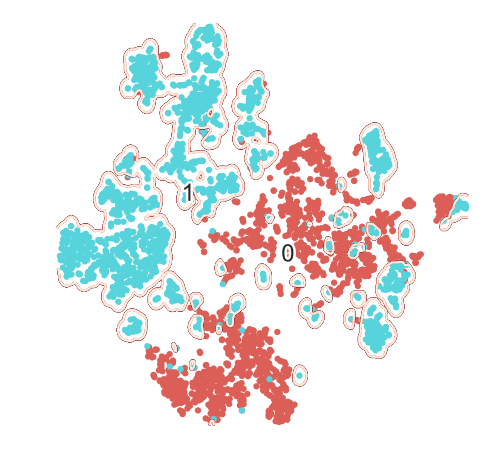

In [15]:
##SVM##
svc = SVC(C = 1,kernel='rbf')
t0 = time.time()
clf = svc.fit(X_train, y_train)
pred_train = clf.predict(X_train)
pred_test = clf.predict(X_test)
print("Time taken to run SVM is : ", time.time() - t0)
print("Training accuracy of SVM is :  ", accuracy_score(pred_train, y_train))
print("Test accuracy of SVM is :  ", accuracy_score(pred_test, y_test))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
ax = plt_scatter(Tsne_X_t, y)
ax.contour(xx, yy, Z, linewidths=2)

### Naive Bayes 

Time taken to run Naive Bayes is :  0.003000974655151367
Training accuracy of Naive Bayes is :   0.867845117845
Test accuracy of Naive Bayes is :   0.85101010101


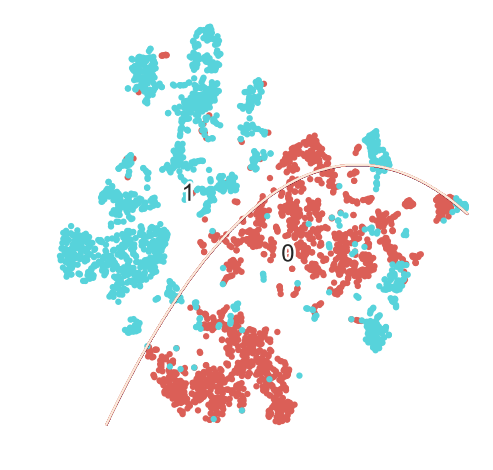

In [16]:
##Naive Bayes##
clf = GaussianNB()
t0 = time.time()
clf.fit(X_train, y_train)
pred_train = clf.predict(X_train)
pred_test = clf.predict(X_test)
print("Time taken to run Naive Bayes is : ", time.time() - t0)
print("Training accuracy of Naive Bayes is :  ", accuracy_score(pred_train, y_train))
print("Test accuracy of Naive Bayes is :  ", accuracy_score(pred_test, y_test))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
ax = plt_scatter(Tsne_X_t, y)
ax.contour(xx, yy, Z, linewidths=2)

### QDA 

Time taken to run QDA is :  0.00553584098815918
Training accuracy of QDA is :   0.839646464646
Test accuracy of QDA is :   0.842171717172


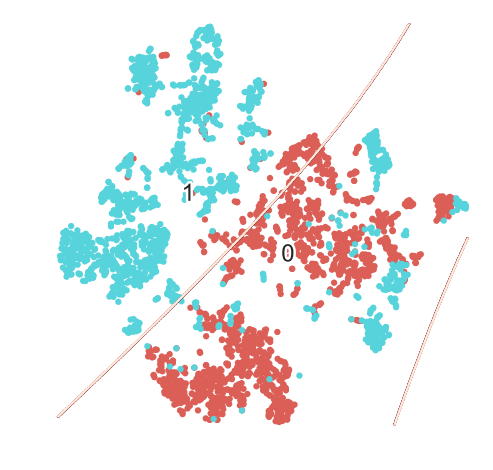

In [17]:
##QDA##

clf = QuadraticDiscriminantAnalysis()
t0 = time.time()
clf.fit(X_train, y_train)
pred_train = clf.predict(X_train)
pred_test = clf.predict(X_test)
print("Time taken to run QDA is : ", time.time() - t0)
print("Training accuracy of QDA is :  ", accuracy_score(pred_train, y_train))
print("Test accuracy of QDA is :  ", accuracy_score(pred_test, y_test))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
ax = plt_scatter(Tsne_X_t, y)
ax.contour(xx, yy, Z, linewidths=2)

### K Nearest Neighbors 

Time taken to run KNN is :  0.012382984161376953
Training accuracy of KNN is :   0.968855218855
Test accuracy of KNN is :   0.954545454545


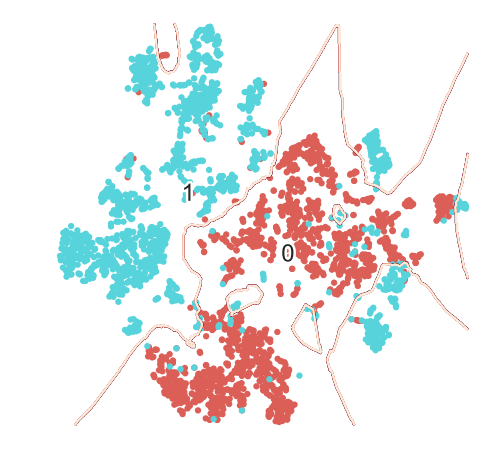

In [18]:
##KNN##
clf = KNeighborsClassifier(n_neighbors=10)
t0 = time.time()
clf.fit(X_train, y_train)
pred_train = clf.predict(X_train)
pred_test = clf.predict(X_test)
print("Time taken to run KNN is : ", time.time() - t0)
print("Training accuracy of KNN is :  ", accuracy_score(pred_train, y_train))
print("Test accuracy of KNN is :  ", accuracy_score(pred_test, y_test))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
ax = plt_scatter(Tsne_X_t, y)
ax.contour(xx, yy, Z, linewidths=2)

### Logistic Regression 

Time taken to run Logistic Regression is :  0.004641056060791016
Training accuracy of Logistic Regression is :   0.808080808081
Test accuracy of Logistic Regression is :   0.800505050505


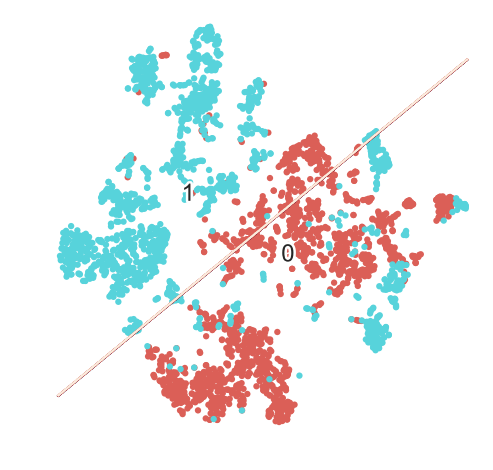

In [19]:
##Logistic regression##
clf = LogisticRegression()
t0 = time.time()
clf.fit(X_train, y_train)
pred_train = clf.predict(X_train)
pred_test = clf.predict(X_test)
print("Time taken to run Logistic Regression is : ", time.time() - t0)
print("Training accuracy of Logistic Regression is :  ", accuracy_score(pred_train, y_train))
print("Test accuracy of Logistic Regression is :  ", accuracy_score(pred_test, y_test))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
ax = plt_scatter(Tsne_X_t, target)
ax.contour(xx, yy, Z, linewidths=2)

### Random Forest 

In [20]:
##Random Forest##
clf = RandomForestClassifier(n_estimators=200)
t0 = time.time()
clf.fit(X_train, y_train)
pred_train = clf.predict(X_train)
pred_test = clf.predict(X_test)
print("Time taken to run Random Forest is : ", time.time() - t0)
print("Training accuracy of Random Forest is :  ", accuracy_score(pred_train, y_train))
print("Test accuracy of Random Forest is :  ", accuracy_score(pred_test, y_test))

Time taken to run Random Forest is :  0.4471170902252197
Training accuracy of Random Forest is :   1.0
Test accuracy of Random Forest is :   0.97095959596


### Gradient Boosting


In [21]:
## Gradient Boosting
clf = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, max_depth=6, subsample=1.0)
t0 = time.time()
clf.fit(X_train, y_train)
pred_train = clf.predict(X_train)
pred_test = clf.predict(X_test)
print("Time taken to run Gradient Boosting is : ", time.time() - t0)
print("Training accuracy of Gradient Boosting is :  ", accuracy_score(pred_train, y_train))
print("Test accuracy of Gradient Boosting is :  ", accuracy_score(pred_test, y_test))

Time taken to run Gradient Boosting is :  0.21262502670288086
Training accuracy of Gradient Boosting is :   0.999579124579
Test accuracy of Gradient Boosting is :   0.964646464646


## Model Ensembling

In [22]:
## Some helper functions
def get_models():
    """Generate a library of base learners."""
    #nb = (GaussianNB())
    svc = (SVC(C = 1,kernel='rbf', probability=True))
    knn = (KNeighborsClassifier(n_neighbors=10))
    #lr = (LogisticRegression())
    #qda = (QuadraticDiscriminantAnalysis())
    gb = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, max_depth=6, subsample=1.0)
    rf = RandomForestClassifier(n_estimators=200)

    models = {'svm': svc,
              'knn': knn,
              #'naive bayes': nb,
              #'qda': qda,
              'rf': rf,
              'gbm': gb,
              #'logistic': lr,
              }

    return models

def train_predict(model_list):
    """Fit models in list on training set and return preds"""
    P = np.zeros((y_test.shape[0], len(model_list)))
    P = pd.DataFrame(P)

    print("Fitting models.")
    cols = list()
    for i, (name, m) in enumerate(models.items()):
        print("%s..." % name, end=" ", flush=False)
        m.fit(X_train, y_train)
        P.iloc[:, i] = m.predict(X_test)
        cols.append(name)
    P.columns = cols
    print("Done.\n")
    return P

def score_models(P, y):
    """Score model in prediction DF"""
    print("Scoring models.")
    for m in P.columns:
        score = accuracy_score(y_test, P.loc[:, m])
        print("%-26s: %.3f" % (m, score))

def predict_prob(model_list):
    P_proba = np.zeros((len(model_list), y_test.shape[0], 2))
    print("Fitting models.")
    for i, (name, m) in enumerate(model_list.items()):
        print("%s..." % name, end=" ", flush=False)
        m.fit(X_train, y_train)
        P_proba[i] = m.predict_proba(X_test)
    print("\n")

    return P_proba

In [23]:
models = get_models()
P = train_predict(models)
score_models(P, y_test)

Fitting models.
svm... knn... rf... gbm... Done.

Scoring models.
svm                       : 0.967
knn                       : 0.955
rf                        : 0.970
gbm                       : 0.965


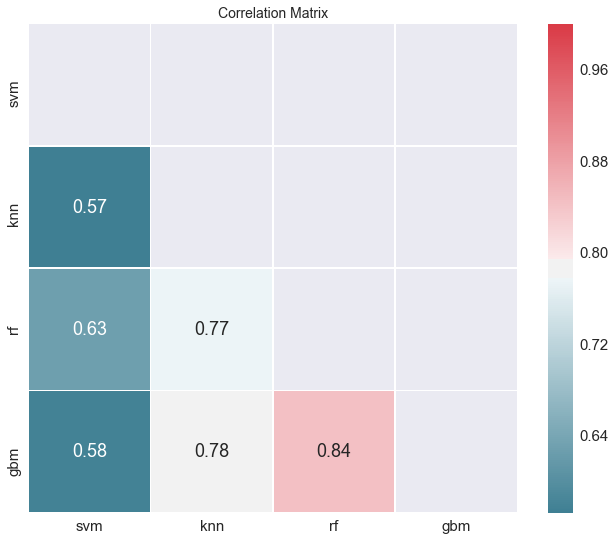

In [24]:
P_c = P.apply(lambda pred: (pred - y_test))
P_c[P_c != 0] = 1
_ = corrmat(P_c.corr(), inflate=False)

## Average Ensembling Model 

In [25]:
P_proba = predict_prob(models)
P_ave = np.mean(P_proba, axis=0)
y_average = np.argmax(P_ave, axis=1)
print("The accuracy percentage of average ensembling model is : ", accuracy_score(y_test, y_average))


Fitting models.
svm... knn... rf... gbm... 

The accuracy percentage of average ensembling model is :  0.968434343434


## True Ensembling Model (Add Meta Learner)

In [26]:
def train_base_learners(base_learners, inp, out, verbose=True):
    """Train all base learners in the library."""
    if verbose: print("Fitting models.")
    for i, (name, m) in enumerate(base_learners.items()):
        if verbose: print("%s..." % name, end=" ", flush=False)
        m.fit(inp, out)
        if verbose: print("done")

            
def predict_base_learners(pred_base_learners, inp, verbose=True):
    """Generate a prediction matrix."""
    P = np.zeros((inp.shape[0], 2, len(pred_base_learners)))

    if verbose: print("Generating base learner predictions.")
    for i, (name, m) in enumerate(pred_base_learners.items()):
        if verbose: print("%s..." % name, end=" ", flush=False)
        p = m.predict_proba(inp)
        # With two classes, need only predictions for one class
        P[:, :,i] = p
        if verbose: print("done")

    return P

def ensemble_predict(base_learners, meta_learner, inp, verbose=True):
    """Generate predictions from the ensemble."""
    P_pred = predict_base_learners(base_learners, inp, verbose=verbose)
    P_pred = P_pred.reshape(P_pred.shape[0], P_pred.shape[1] * P_pred.shape[2])
    return P_pred, meta_learner.predict(P_pred)

In [27]:
#step1 Define base learners
base_learners = get_models()


#step2 Define a meta learner


meta_learner = GradientBoostingClassifier(
    n_estimators=1000,
    max_features=4,
    max_depth=3,
    subsample=0.5,
    learning_rate=0.005, 
    random_state=RS
)


#Split the training set
xtrain_base, xpred_base, ytrain_base, ypred_base = train_test_split(
    X_train, y_train, test_size=0.5, random_state=RS)


In [28]:
#Train base learners on the training set
train_base_learners(base_learners, xtrain_base, ytrain_base)

Fitting models.
svm... done
knn... done
rf... done
gbm... done


In [29]:
#Predict on the base models
P_base = predict_base_learners(base_learners, xpred_base)
P_base = P_base.reshape(P_base.shape[0], P_base.shape[1] * P_base.shape[2])

Generating base learner predictions.
svm... done
knn... done
rf... done
gbm... done


In [30]:
#Fit and predict on meta learner
meta_learner.fit(P_base, ypred_base)
P_pred, p = ensemble_predict(base_learners, meta_learner, X_test, verbose=False)
print("True Ensemble accuracy score: %.3f" % accuracy_score(y_test, p))

True Ensemble accuracy score: 0.965
